## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [ ]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
# 1:

data="//wsl.localhost/Ubuntu/home/morden/data/data_000637.txt"

with open(data) as f:
    row_count = sum(1 for line in f)
print(f"The file has {row_count} rows.")

N = np.random.randint(10000, row_count)

The file has 1310721 rows.


In [11]:
dataset = pd.read_csv(data, nrows=N)
dataset.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25


In [22]:
# 2:

x = dataset['BX_COUNTER'].max() + 1
print(f"The number of BX in an ORBIT is: {x}")

The number of BX in an ORBIT is: 3564


In [33]:
# 3:

dataset_end = pd.read_csv(data, skiprows=lambda x: x > 1 and x < (row_count - 10))

BX_PER_ORBIT = 3564
NS_PER_BX = 25

orbit_start = dataset_end['ORBIT_CNT'].iloc[0]
orbit_end = dataset_end['ORBIT_CNT'].iloc[-1]

bx_start = dataset_end['BX_COUNTER'].iloc[0]
bx_end = dataset_end['BX_COUNTER'].iloc[-1]

delta_orbits = orbit_end - orbit_start
total_bx_elapsed = (delta_orbits * BX_PER_ORBIT) + (bx_end - bx_start)

duration_seconds = (total_bx_elapsed * NS_PER_BX) / 1e9

print(f"The data taking lasted: {duration_seconds:.4f} seconds")

The data taking lasted: 0.9804 seconds


In [35]:
# 4:

TDC_CONVERSION = 25 / 30

START_ORBIT = dataset['ORBIT_CNT'].iloc[0]
START_BX = dataset['BX_COUNTER'].iloc[0]
START_TDC = dataset['TDC_MEAS'].iloc[0]

dataset['NS'] = (
    (dataset['ORBIT_CNT'] - START_ORBIT) * BX_PER_ORBIT * NS_PER_BX + 
    (dataset['BX_COUNTER'] - START_BX) * NS_PER_BX + 
    (dataset['TDC_MEAS'] - START_TDC) * TDC_CONVERSION
)

dataset.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,NS
0,1,0,123,3869200167,2374,26,0.000000
1,1,0,124,3869200167,2374,27,0.833333
2,1,0,63,3869200167,2553,28,4476.666667
3,1,0,64,3869200167,2558,19,4594.166667
4,1,0,64,3869200167,2760,25,9649.166667


In [40]:
# 5:

dataset['HEAD'] = np.random.randint(0, 2, size=len(dataset))
dataset.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,NS
0,1,0,123,3869200167,2374,26,0.000000
1,0,0,124,3869200167,2374,27,0.833333
2,1,0,63,3869200167,2553,28,4476.666667
3,0,0,64,3869200167,2558,19,4594.166667
4,0,0,64,3869200167,2760,25,9649.166667


In [44]:
# 6:

new_dataframe = dataset[dataset['HEAD'] == 1].reset_index(drop=True)
new_dataframe.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,NS
0,1,0,123,3869200167,2374,26,0.000000
1,1,0,63,3869200167,2553,28,4476.666667
2,1,0,139,3869200167,2776,0,10028.333333
3,1,0,62,3869200167,2774,21,9995.833333
4,1,1,7,3869200167,2785,4,10256.666667


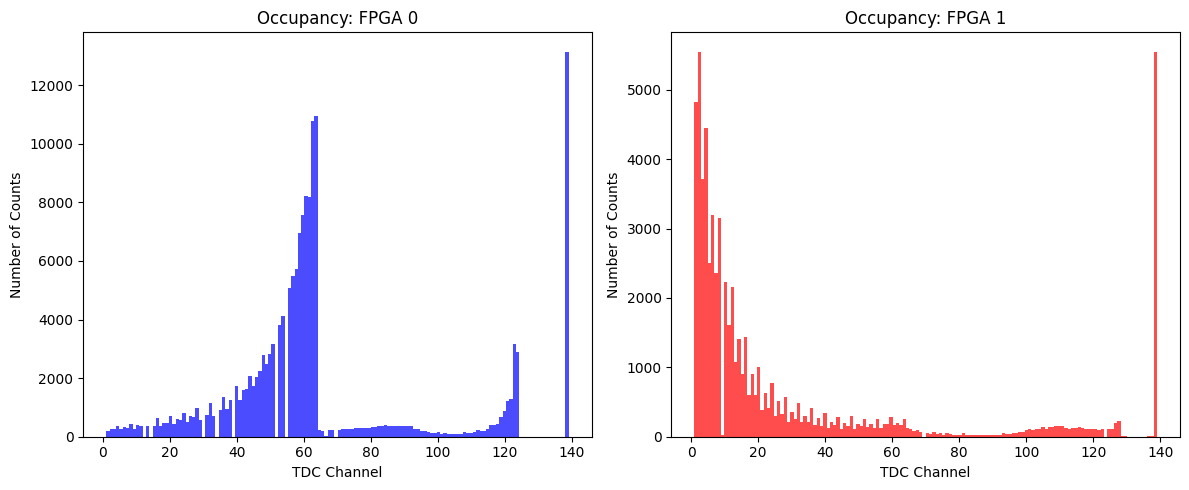

In [53]:
# 7:

fpga_0 = dataset[dataset['FPGA'] == 0]
fpga_1 = dataset[dataset['FPGA'] == 1]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
plt.hist(fpga_0['TDC_CHANNEL'], bins=140, color='blue', alpha=0.7)
plt.title('Occupancy: FPGA 0')
plt.xlabel('TDC Channel')
plt.ylabel('Number of Counts')

plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
plt.hist(fpga_1['TDC_CHANNEL'], bins=140, color='red', alpha=0.7)
plt.title('Occupancy: FPGA 1')
plt.xlabel('TDC Channel')
plt.ylabel('Number of Counts')

plt.tight_layout()
plt.show()

In [54]:
# 8:

noisy_0 = fpga_0.groupby('TDC_CHANNEL').size().sort_values(ascending=False).head(3)

noisy_1 = fpga_1.groupby('TDC_CHANNEL').size().sort_values(ascending=False).head(3)

print("--- Top 3 Noisy Channels: FPGA 0 ---")
print(noisy_0)
print("\n--- Top 3 Noisy Channels: FPGA 1 ---")
print(noisy_1)

--- Top 3 Noisy Channels: FPGA 0 ---
TDC_CHANNEL
139    13144
64     10935
63     10778
dtype: int64

--- Top 3 Noisy Channels: FPGA 1 ---
TDC_CHANNEL
139    5549
2      5538
1      4817
dtype: int64


In [110]:
# 9:

unique_orbits = dataset['ORBIT_CNT'].nunique()
print(f"The number of unique orbits is: {unique_orbits}")

hits_139 = dataset[dataset['TDC_CHANNEL'] == 139]
unique_orbits_139 = hits_139['ORBIT_CNT'].nunique()

print(f"The number of unique orbits with at least one count in 139 is: {unique_orbits_139}")

The number of unique orbits is: 2238
The number of unique orbits with at least one count in 139 is: 2235
